# A visual comparison of MLPs and Convolutional Networks 

### very loosely based on example visualisation code  from a Kaggle example  and "towards data science"

This notebook contrasts how simple  [Multi-layer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) (MLP) Neural Networks and Convolutional Neural Networks recognize hand-written digits from the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) data set. 

* A two-layer MLP does a decent job at recognizing hand-written digits.

* A very simple convolutional model does even better (though still not close to the 'state of the art')
* There is considerable difference in the *interpretability* of the features

Author @Jim Smith james.smith@uwe.ac.uk 2023,2025

In [22]:
import numpy as np
import pandas as pd
import os
import socket
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical, plot_model
from keras.datasets import mnist
from keras import backend as K





# First load and transform the mnist data
Just to speed thing up we will only take 20% of the data

In [23]:
#if (socket.gethostname()=='csctcloud'): #on csctcloud
#    path="/home/common/datasets/mninst"
#else: #machie specific- this is for jim's development
path = "../datasets/mnist/"

#path = "../../shared/datasets/mnist/"
fraction= 5 #i.e use 1/5th of data

data = pd.read_csv(path +'mnist_train.csv')
x_train = data.iloc[:data.shape[0],1:785]
x_train = x_train.values.reshape(data.shape[0], 784)
x_train = x_train[:x_train.shape[0]//5,:]
y_train = data.iloc[:data.shape[0]//fraction,0]

testdata = pd.read_csv(path + 'mnist_test.csv')
x_test = testdata.iloc[:testdata.shape[0],1:785]
x_test = x_test.values.reshape(testdata.shape[0], 784)
x_test = x_test[:x_test.shape[0]//5,:]
y_test = testdata.iloc[:testdata.shape[0]//fraction,0]

# compute the number of labels
num_labels = len(np.unique(y_train))

# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# normalize
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#make version in 2d format for conv nets
X_train_img = x_train.reshape(x_train.shape[0],28,28,1)
X_test_img = x_test.reshape(x_test.shape[0],28,28,1)

### Visalise some examples

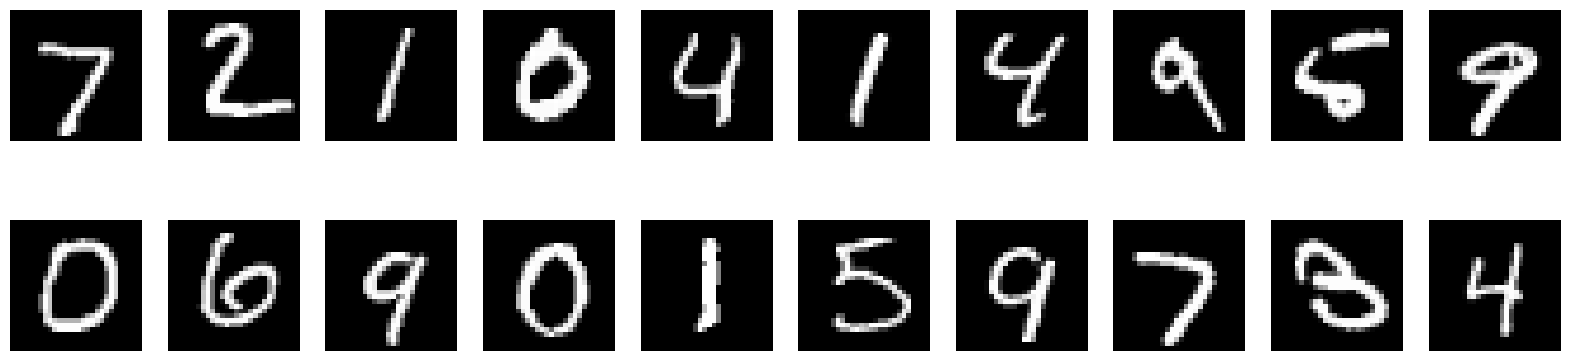

In [24]:
f, axes = plt.subplots(2, 10, sharey=True,figsize=(20,5))
for i,ax in enumerate(axes.flat):
    ax.axis('off')
    ax.imshow(X_test_img[i,:,:,0],cmap="gray")

# Part 1: Specifying and Training a simple Neural  Network (MLP)

We use a simple two-layer MLP with sigmoid activation 
<img align="right" src="images/simple_MLP_for_Mnist.png" alt="Architecture of simple MLP, only 28 inputs shown" width="400"/>
 
**Note that. tyhis image only shows the first 28 of the (28 x 28=) 784 actual inputs** 
 
* In the first hidden layer, each neuron takes every pixel value as input parameter. 
* Every neuron in the second hidden layer then takes all the outputs of the first layer (after activation using sigmoid) as input parameters. 
* After applying a softmax activation, these results form the final output layer. 

The optimizer then derives linear weights in such a way as to minimize the loss function (in this case the *categorical crossentropy*) and thus maximizing the accuracy of the classification.

In [25]:
# network parameters
input_size = x_train.shape[1]
batch_size = 64
activation = 'sigmoid'
# this model is a 3-layer MLP with sigmoid activation each layer
model = Sequential()
model.add(Dense(25, input_dim=input_size, activation='sigmoid'))
model.add(Dense(25,activation='sigmoid'))
model.add(Dense(num_labels,activation='softmax'))
model.summary()

# loss function for one-hot vector using adam optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                19625     
                                                                 
 dense_4 (Dense)             (None, 25)                650       
                                                                 
 dense_5 (Dense)             (None, 10)                260       
                                                                 
Total params: 20535 (80.21 KB)
Trainable params: 20535 (80.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Now train the model on our subset of the  MNIST training data set:

In [26]:
# train the network
model.fit(x_train, y_train, epochs=20, batch_size=batch_size)

# validate the model on test dataset to determine generalization
loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

Epoch 1/20
188/188 [==============================] - 0s 792us/step - loss: 2.0046 - accuracy: 0.4587
Epoch 2/20
188/188 [==============================] - 0s 797us/step - loss: 1.3645 - accuracy: 0.7236
Epoch 3/20
188/188 [==============================] - 0s 799us/step - loss: 0.9489 - accuracy: 0.8424
Epoch 4/20
188/188 [==============================] - 0s 803us/step - loss: 0.6916 - accuracy: 0.8791
Epoch 5/20
188/188 [==============================] - 0s 870us/step - loss: 0.5362 - accuracy: 0.8963
Epoch 6/20
188/188 [==============================] - 0s 837us/step - loss: 0.4425 - accuracy: 0.9072
Epoch 7/20
188/188 [==============================] - 0s 837us/step - loss: 0.3808 - accuracy: 0.9157
Epoch 8/20
188/188 [==============================] - 0s 836us/step - loss: 0.3396 - accuracy: 0.9212
Epoch 9/20
188/188 [==============================] - 0s 807us/step - loss: 0.3084 - accuracy: 0.9258
Epoch 10/20
188/188 [==============================] - 0s 822us/step - loss: 0.284

This model implementation reaches an accuracy of ~96% if we give it the whole training set, which is remarkable, but better results are possible using, e.g., a [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network). We use the simpler MLP to make the interpretation of the visualization results easier.

## Extract Output and Group Information

We extract the outputs generated by each individual neuron and for each frame in the MNIST training sample and store them on a per-layer basis. 

In [8]:
get_layer_output = K.function( inputs = model.layers[0].input,
                              outputs=[model.layers[0].output, model.layers[1].output, model.layers[2].output])

layer1_output, layer2_output, layer3_output = get_layer_output([x_train])

Finally, we extract and store the indices of frames showing the same digit.

In [9]:
train_ids = [np.arange(len(y_train))[y_train[:,i] == 1] for i in range(10)]

## Visualization of  Individual Frames

In this visualization, we focus on individual training data (i.e., individual frames with hand-written digits).

The following panel shows from left to right 
* the original 28x28 pixel frame depicting a hand-written figure,
* the output values of all neurons of the first hidden layer,
* the output values of all neurons of the second hidden layer, and
* the one-hot encoded output layer indicating the model classification result.

Note that in those plots showing network layers, each pixel stands for the output of a single neuron. This output is based on the input parameters passed on from the previous layer, the trained weights for each neuron, and the activation function used in this layer. Dark blue pixels stand for low output values, while yellow pixels stand for high output values. The pixels have been arranged in two dimensions to save space; just think of these layers in linear arrangements to stay in the typical picture of layers in a network. 

In [10]:
%%capture
%matplotlib inline

# digit to be plotted
digit = 4

# indices of frames to be plotted for this digit
n = range(50)

# initialize plots
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,4))

# prepare plots
ax1.set_title('Input Layer', fontsize=16)
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

ax2.set_title('Hidden Layer 1', fontsize=16)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

ax3.set_title('Hidden Layer 2', fontsize=16)
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
    
ax4.set_title('Output Layer', fontsize=16)
ax4.axes.get_xaxis().set_visible(False)
ax4.axes.get_yaxis().set_visible(False)   

# add numbers to the output layer plot to indicate label
for i in range(3):
    for j in range(4):
        text = ax4.text(j, i, [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, '', '']][i][j],
                        ha="center", va="center", color="w", fontsize=16)    
        
def animate(id):
    # plot elements that are changed in the animation
    digit_plot = ax1.imshow(x_train[train_ids[digit][id]].reshape((28,28)), animated=True)
    layer1_plot = ax2.imshow(layer1_output[train_ids[digit][id]].reshape((5,5)), animated=True)
    layer2_plot = ax3.imshow(layer2_output[train_ids[digit][id]].reshape((5,5)), animated=True)
    output_plot = ax4.imshow(np.append(layer3_output[train_ids[digit][id]], 
                                       [np.nan, np.nan]).reshape((3,4)), animated=True)
    return digit_plot, layer1_plot, layer2_plot, output_plot,

# define animation
ani = matplotlib.animation.FuncAnimation(f, animate, frames=n, interval=100)

In [11]:
ani

Scrolling through the animation, it becomes clear that in most cases the same subset of neurons fires, while other neurons remain turned off.

This is much more obvious in the second hidden layer than in the first hidden layer.

It can be interpreted as the first layer pre-processesing the pixel data,  
while the second layer deals with pattern recognition.  
Note that in most cases the recognition of the digit shown is unambiguous; ambiguity only occurs in somewhat pathologic cases.

You can change the digit shown by changing the `digit` value in the code block above. 

## Conclusions

* Despite variations in the shapes of hand-written digits, the same groups of neurons is involved in the identification of the same digits.
* Similarities in the shapes of digits translate into similarities in the groups of neurons that are involved in their identification in the first hidden layer, but not so much in the second hidden layer.

# now with a conv-net
adapted from notebook at 
https://towardsdatascience.com/visualizing-intermediate-activations-of-a-cnn-trained-on-the-mnist-dataset-2c34426416c8

my version uses a **much** simpler convolutional structure and changes some of the viusualisations


In [27]:
def cmodel(c_width1:int,c_width2:int, fc_width:int):
    
    inputs = Input(shape=(28,28,1))  
    x = Conv2D(c_width1,kernel_size=(5,5),padding='same',activation="relu",name=f"conv1_{c_width1}x5x5")(inputs) 
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool_2x2")(x) # 8 x (14 x 14)  
    x = Conv2D(c_width2, (3, 3), padding='same',activation='relu',name=f"conv2_{c_width2}x3x3")(x)
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool2_2x2")(x)
    x = Flatten()(x)
    x = Dense(fc_width, activation='relu',name=f"dense1_{fc_width}")(x)
    
    output = Dense(num_classes,activation="softmax",name="dense_10")(x)
    
    model = Model(inputs,output)
    model.summary()
    model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
    
    
    return model

In [28]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_train_img,y_train,test_size=0.20, random_state=42)
  
batch_size=256
num_classes = 10
epochs = 20
c_width1=8
c_width2 =8
fc_width=20
conv_model = cmodel(c_width1=c_width1,c_width2=c_width2,fc_width=fc_width)  

history = conv_model.fit(X_train2,Y_train2,
         epochs=epochs,
         batch_size=batch_size,
         validation_data=(X_test2,Y_test2))


loss, acc = conv_model.evaluate(X_test2, Y_test2, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv1_8x5x5 (Conv2D)        (None, 28, 28, 8)         208       
                                                                 
 maxpool_2x2 (MaxPooling2D)  (None, 14, 14, 8)         0         
                                                                 
 conv2_8x3x3 (Conv2D)        (None, 14, 14, 8)         584       
                                                                 
 maxpool2_2x2 (MaxPooling2D  (None, 7, 7, 8)           0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 392)               0         
                                                           

# A very simple Convolutional Architecture

<img align="centre" src="images/convnet_fig.png" alt="Architecture of simple 2-layer conv net architecture" width="600"/>



## First let's look at the learned weights for each filter in our trained model
Because as we saw, this is what they will respond to in the input

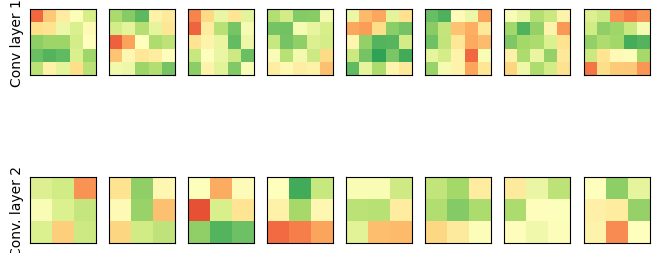

In [14]:
fig,axs =plt.subplots(2,max(c_width1, c_width2),figsize=(8, 4))

axs[0][0].set_ylabel('Conv layer 1', fontsize=10)
for col in range (c_width1):
    weights = conv_model.get_weights()[0][:,:,0,col]
    axs[0][col].imshow(weights, cmap='RdYlGn',vmin=-0.5,vmax=0.5)

axs[1][0].set_ylabel('Conv. layer 2', fontsize=10)
for col in range (c_width1):
    weights=  conv_model.get_weights()[2][:,:,0,col]
    axs[1][col].imshow(weights, cmap='RdYlGn',vmin=-0.5,vmax=0.5)

    
#turn off annoying tick makrs
for axrow in axs:
    for axcol in axrow:
        axcol.set_xticks([])
        axcol.set_yticks([])

## Now we can look at the layer activations for this different architecture

In [15]:
layer_outputs = [layer.output for layer in conv_model.layers[1:7]]
activation_model = Model(inputs=conv_model.input,outputs=layer_outputs)

In [16]:

#get list of all training images for each digit
digit=4
img_ids = [np.arange(len(Y_train2))[Y_train2[:,i] == 1] for i in range(10)]

imgs =X_train2[img_ids[digit]]

activations = activation_model.predict(imgs[0].reshape(1,28,28,1))



1/1 [==============================] - 0s 95ms/step


In [17]:
#Get layer names and descriptions

cols_in_fig=0
layer_names = []
layer_sizes= []
for layer in range(len(activations)):
    layer_name= conv_model.layers[layer].name
    print(f' layer {layer}  {layer_name} shape {activations[layer].shape}')
    if len(activations[layer].shape)==4:
        cols_in_fig+=1
        layer_names.append(layer_name) 
        layer_sizes.append(activations[layer].shape)
print(layer_names,layer_sizes)

 layer 0  input_1 shape (1, 28, 28, 8)
 layer 1  conv1_8x5x5 shape (1, 14, 14, 8)
 layer 2  maxpool_2x2 shape (1, 14, 14, 8)
 layer 3  conv2_8x3x3 shape (1, 7, 7, 8)
 layer 4  maxpool2_2x2 shape (1, 392)
 layer 5  flatten shape (1, 20)
['input_1', 'conv1_8x5x5', 'maxpool_2x2', 'conv2_8x3x3'] [(1, 28, 28, 8), (1, 14, 14, 8), (1, 14, 14, 8), (1, 7, 7, 8)]


In [18]:

#Make plot to animate
columns= len(layer_names)
rows=max(c_width1,c_width2)
fig,axs =plt.subplots(rows,columns,figsize=(5, 8))

for col in range(columns):
    axs[0][col].set_title(layer_names[col],fontsize=10)

col0 = axs[c_width1//2][0].imshow(imgs[0,:,:,0],cmap="gray")

#go through layers adding empty images
for row in range(c_width1):#layer_sizes[1][3]):
    the_output= axs[row][1].imshow( np.zeros((layer_sizes[1][1],layer_sizes[1][2])),cmap='RdYlGn')

for row in range(c_width1):#layer_sizes[2][3]):
    the_output= axs[row][2].imshow( np.zeros((layer_sizes[2][1],layer_sizes[2][2])),cmap='RdYlGn')


#col3 = []
for row in range(c_width2):#layer_sizes[3][3]):
    the_output= axs[row][3].imshow( np.zeros((layer_sizes[3][1],layer_sizes[3][2])),cmap='RdYlGn')

for axrow in axs:
    for axcol in axrow:
        axcol.set_xticks([])
        axcol.set_yticks([])

plt.close()


In [19]:
def animate(id):
    
    activations = activation_model.predict(imgs[id].reshape(1,28,28,1),verbose=1)

    col0.set_data(imgs[id])
    
    for row in range( c_width1):
        col1_img=np.zeros((28,28))
        col2_img=np.zeros((14,14))
  
        
        for arow in range(28):
            for acol in range(28):
                col1_img[arow][acol]= activations[0][0][arow][acol][row]
        axs[row][1].imshow(col1_img,cmap='RdYlGn')
        
        for brow in range (14):
            for bcol in range(14):
                col2_img[brow][bcol]=activations[1][0][brow][bcol][row]
        axs[row][2].imshow(col2_img,cmap='RdYlGn')

    for row in range( c_width2):
        col3_img=np.zeros((14,14))
        for crow in range (14):
            for ccol in range(14):
                col3_img[crow][ccol]=activations[2][0][crow][ccol][row]
        axs[row][3].imshow(col3_img,cmap='RdYlGn')
    
    return col0

In [20]:
num_to_show=50
ani =   matplotlib.animation.FuncAnimation(fig, animate, frames=num_to_show, interval=50)   


In [21]:
ani

1/1 [==============================] - 0s 8ms/step


# Conclusions
- which were more interpretable?
- size of networks
- avoiding risk of overfitting  
  **what else could have been done to avoid over-fitting?**
